# **1. GAN**
GAN(Generative Adversarial Network)은 생성자(Generator)와 판별자(Discriminator)라는 두 신경망이 경쟁하며 학습하는 구조입니다. 생성자는 무작위 노이즈로부터 실제와 구분하기 어려운 데이터를 만들어내고, 판별자는 입력된 데이터가 진짜(실제 데이터)인지 가짜(생성자 출력)인지 구별하려 합니다. 학습 과정에서 생성자는 판별자를 속이도록 점점 더 현실적인 데이터를 만들고, 판별자는 더 정밀하게 구분하도록 발전하여, 최종적으로는 매우 사실적인 이미지나 데이터 생성이 가능해집니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FcU5Nst%2FbtsPTkGJ9d4%2FAAAAAAAAAAAAAAAAAAAAAGeL0xDtWqUMCwsvyiigYqZlYFhKUV96mOvGhonME7Ue%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1756652399%26allow_ip%3D%26allow_referer%3D%26signature%3DGeY9sYzZTMIP%252FiX4v8OChGfY2ss%253D'>

# **2. GAN의 기본 아이디어**

GAN(Generative Adversarial Network)은 두 개의 인공지능이 서로 경쟁하며 발전하는 구조입니다.

- 생성자(Generator): “나는 진짜처럼 보이는 가짜 데이터를 만들 거야.”
- 판별자(Discriminator): “이 데이터가 진짜인지 가짜인지 내가 구분해 줄게.”

이 두 모델이 서로 경쟁하는데, 마치 위조지폐범(생성자)과 형사(판별자)의 대결과 비슷합니다.

- 위조지폐범은 점점 더 정교하게 위조지폐를 만듭니다.
- 형사는 점점 더 눈썰미가 좋아져서 위조를 잘 잡아냅니다.
이 과정을 반복하면, 결국 위조지폐는 진짜와 거의 구분이 안 갈 정도로 정교해집니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2F3Ml4F%2FbtsPS1UYrLp%2FAAAAAAAAAAAAAAAAAAAAAO0c7U5yHlCbFf_3arXE1MMzo7fwQ7mnmKYFhYu1nDMA%2Fimg.jpg%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1756652399%26allow_ip%3D%26allow_referer%3D%26signature%3DqK%252BrpbRYv%252BDlDnN1BrF%252FIFDQJ08%253D'>


# **3. GAN의 학습**


In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128))) # H, W, C
generator.add(UpSampling2D()) # 14 * 14
generator.add(Conv2D(64, kernel_size=5, padding='same')) # 14 * 14 * 64
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())# 28 * 28 * 64
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) # 그레이스케일, 출력 범위 -1 ~ 1

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same")) # 14 * 14, 1 -> 64
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same")) # 7 * 7, 128
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# 결합 모델을 컴파일 한 뒤에 trainable를 변경하게 되면 다시 컴파일이 필요함
# 가중치가 학습(업데이트)되지 않음
# 판별자만 학습: 진짜 이미지: 1, 생성 이미지: 0로 구분하도록 가중치만 업데이트
# 생성자만 학습: 입력 잡음을 통과시켜 판별자를 속여 1로 나오게 가중치를 업데이트. 판별자를 고정
discriminator.trainable = False

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │       865,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

In [ ]:
# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

    # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분입니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력하는 부분입니다.
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차를 계산합니다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # 실제 이미지와 가상 이미지에 대한 판별자의 오차를 평균냄
        g_loss = gan.train_on_batch(noise, true)  # 생성자를 학습 (가상 이미지를 실제 이미지로 잘 속이도록 학습)

        # train_on_batch() 결과가 리스트이면 첫 번째 값 사용
        if isinstance(d_loss, list):
            d_loss = d_loss[0]
        if isinstance(g_loss, list):
            g_loss = g_loss[0]

        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
        if i % saving_interval == 0:
            #r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("./gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os, math, numpy as np, tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import Model, Sequential
# ------------------------------------------------------------
# 설정
# ------------------------------------------------------------
IMG_SHAPE = (28, 28, 1)     # 데이터 모양
Z_DIM     = 100             # 노이즈 차원
BATCH     = 128
EPOCHS    = 50
LR        = 2e-4
BETA1     = 0.5
SEED      = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
def load_dataset():
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    x = x_train.astype("float32")
    x = np.expand_dims(x, axis=-1)         # (N, 28, 28, 1)
    x = (x / 127.5) - 1.0                  # [0,255] -> [-1,1]
    ds = tf.data.Dataset.from_tensor_slices(x)
    ds = ds.shuffle(60000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds
def build_generator(z_dim=Z_DIM):
    # 28x28x1을 만드는 간단한 DCGAN 제너레이터
    g = Sequential(name="generator")
    g.add(L.Input(shape=(z_dim,)))
    g.add(L.Dense(7*7*128, use_bias=False))
    g.add(L.BatchNormalization())
    g.add(L.LeakyReLU(0.2))
    g.add(L.Reshape((7, 7, 128)))
    g.add(L.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False))
    g.add(L.BatchNormalization())
    g.add(L.LeakyReLU(0.2))
    g.add(L.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))
    return g
def build_discriminator(img_shape=IMG_SHAPE):
    d = Sequential(name="discriminator")
    d.add(L.Input(shape=img_shape))
    d.add(L.Conv2D(64, 5, strides=2, padding="same"))
    d.add(L.LeakyReLU(0.2))
    d.add(L.Dropout(0.3))
    d.add(L.Conv2D(128, 5, strides=2, padding="same"))
    d.add(L.LeakyReLU(0.2))
    d.add(L.Dropout(0.3))
    d.add(L.Flatten())
    d.add(L.Dense(1, activation="sigmoid"))
    return d
g = build_generator()
d = build_discriminator()
d.trainable = True
opt_d = tf.keras.optimizers.Adam(LR, beta_1=BETA1)
d.compile(optimizer=opt_d, loss="binary_crossentropy", metrics=["accuracy"])
d.trainable = False
z_in = L.Input(shape=(Z_DIM,))
valid = d(g(z_in))
combined = Model(z_in, valid, name="G_with_frozen_D")
opt_g = tf.keras.optimizers.Adam(LR, beta_1=BETA1)
combined.compile(optimizer=opt_g, loss="binary_crossentropy")
# (참고) 여기서 d.trainable을 True로 돌려놔도, d는 이미 train용으로 컴파일된 상태라
# 이후 루프에서 다시 토글/재컴파일할 필요가 전혀 없습니다.
d.trainable = True
# ------------------------------------------------------------
# 학습 루프 (루프 안에서는 절대 trainable 토글 금지!)
# ------------------------------------------------------------
def smooth_labels(y, low=0.9, high=1.0):
    # one-sided label smoothing (real만)
    return tf.random.uniform(tf.shape(y), minval=low, maxval=high)
def maybe_flip(y, p=0.03):
    mask = tf.cast(tf.random.uniform(tf.shape(y)) < p, y.dtype)
    return y * (1 - mask) + (1 - y) * mask
def train(epochs=EPOCHS):
    ds = load_dataset()
    num_batches = None
    for epoch in range(1, epochs + 1):
        d_losses, g_losses = [], []
        for step, real in enumerate(ds, start=1):
            bs = tf.shape(real)[0]
            z = tf.random.normal((bs, Z_DIM))
            fake = g(z, training=False)
            y_real = smooth_labels(tf.ones((bs, 1), dtype=tf.float32), 0.85, 1.0)
            y_fake = tf.zeros((bs, 1), dtype=tf.float32)
            # (optional) flip a small portion
            y_real = maybe_flip(y_real, p=0.02)
            y_fake = maybe_flip(y_fake, p=0.02)
            d_loss_real = d.train_on_batch(real, y_real, return_dict=True)
            d_loss_fake = d.train_on_batch(fake, y_fake, return_dict=True)
            d_loss = {
                "loss": 0.5 * (d_loss_real["loss"] + d_loss_fake["loss"]),
                "acc":  0.5 * (d_loss_real["accuracy"] + d_loss_fake["accuracy"]),
            }
            d_losses.append(d_loss["loss"])
            z = tf.random.normal((bs, Z_DIM))
            g_loss = combined.train_on_batch(z, tf.ones((bs, 1)), return_dict=True)
            g_losses.append(g_loss["loss"])
            num_batches = step
        print(f"epoch:{epoch:>3d}  d_loss:{np.mean(d_losses):.4f}  g_loss:{np.mean(g_losses):.4f}  (steps:{num_batches})")
train(EPOCHS)
def sample_images(rows=5, cols=5):
    import matplotlib.pyplot as plt
    z = tf.random.normal((rows*cols, Z_DIM))
    gen = g.predict(z, verbose=0)
    # [-1,1] -> [0,1]
    gen = (gen + 1.0) / 2.0
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    for i, ax in enumerate(axes.flat):
        img = gen[i, :, :, 0]
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    os.makedirs("samples", exist_ok=True)
    plt.savefig("samples/grid.png", dpi=150)
    plt.close()

In [ ]:
sample_images()

# **4. DCGAN**
DCGAN(Deep Convolutional GAN)은 전통적인 GAN 구조에 합성곱 신경망(CNN)을 적용하여 이미지 생성에 최적화된 모델입니다. 생성자는 전치 합성곱(ConvTranspose2D)을 사용해 무작위 노이즈를 점점 업샘플링하며 이미지를 만들고, 판별자는 합성곱(Conv2D)으로 이미지를 다운샘플링하며 진짜·가짜를 구분합니다. 또한 배치 정규화와 LeakyReLU/Tanh 활성화 등을 도입해 학습을 안정화하고, 풀링 연산 대신 스트라이드 합성곱을 사용하여 이미지의 공간적 패턴을 보존합니다. 그 결과 DCGAN은 보다 선명하고 사실적인 이미지를 생성할 수 있으며, 이후 다양한 GAN 변형 모델들의 기반이 되었습니다. [[논문]](https://arxiv.org/abs/1511.06434)



In [1]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import Food101
from torchvision.transforms import v2

In [3]:
manualSeed = 2025
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# 같은 입력과 같은 코드를 항상 동일한 출력
torch.use_deterministic_algorithms(True)

In [4]:
image_size = 64
dataset = Food101(root=".", split="train", download=True,
                  transform=v2.Compose([
                      v2.ToImage(),
                      v2.Resize((image_size, image_size), antialias=True),
                      v2.ToDtype(torch.float32, scale=True),
                      v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                  ]))

100%|██████████| 5.00G/5.00G [03:57<00:00, 21.0MB/s]


In [5]:
workers = 2
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

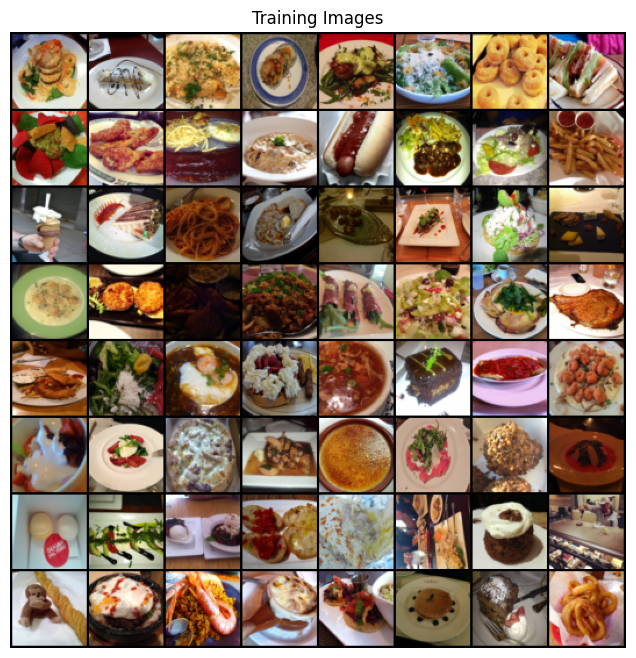

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
      # 가중치를 평군:0, 표준편차:0.02 (DCGAN 논문에서 추천한 초기화 방법)
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
      # 가중치를 스케일 파라미터 y: 1, b: 0
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
nc = 3        # 출력 이미지 채널 수
ngf = 64      # 기본 채널 크기
nz = 100      # 잠재벡터(노이즈)차원 (batch, nz, 1, 1)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 커널, 스트라이드, 패딩
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [13]:
ndf = 64

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [16]:
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [17]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [18]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 5

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ###################
        netD.zero_grad()

        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real).view(-1)

        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()
        ###################
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()
        ###################


        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}] [{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")


        G_losses.append(errG.item())
        D_losses.append(errD.item())


        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5] [0/592]	Loss_D: 1.3458	Loss_G: 5.3086	D(x): 0.5348	D(G(z)): 0.4040 / 0.0066
[0/5] [50/592]	Loss_D: 0.0996	Loss_G: 9.5234	D(x): 0.9263	D(G(z)): 0.0003 / 0.0002
[0/5] [100/592]	Loss_D: 0.3292	Loss_G: 5.1946	D(x): 0.9486	D(G(z)): 0.2259 / 0.0080
[0/5] [150/592]	Loss_D: 0.2929	Loss_G: 4.7916	D(x): 0.8664	D(G(z)): 0.1036 / 0.0144
[0/5] [200/592]	Loss_D: 0.4149	Loss_G: 6.4831	D(x): 0.8757	D(G(z)): 0.2031 / 0.0023
[0/5] [250/592]	Loss_D: 1.3559	Loss_G: 1.2127	D(x): 0.4408	D(G(z)): 0.1154 / 0.3822
[0/5] [300/592]	Loss_D: 0.7266	Loss_G: 5.0638	D(x): 0.8844	D(G(z)): 0.3930 / 0.0128
[0/5] [350/592]	Loss_D: 0.2239	Loss_G: 3.3464	D(x): 0.9016	D(G(z)): 0.0893 / 0.0478
[0/5] [400/592]	Loss_D: 1.8011	Loss_G: 12.0987	D(x): 0.9535	D(G(z)): 0.7207 / 0.0000
[0/5] [450/592]	Loss_D: 0.6800	Loss_G: 3.7458	D(x): 0.7934	D(G(z)): 0.3202 / 0.0326
[0/5] [500/592]	Loss_D: 0.4180	Loss_G: 5.4610	D(x): 0.9057	D(G(z)): 0.2330 / 0.0074
[0/5] [550/592]	Loss_D: 0.2826	Loss_G: 4.3999	D(x): 0.8088	D(G(z)): 0.0255 / 0

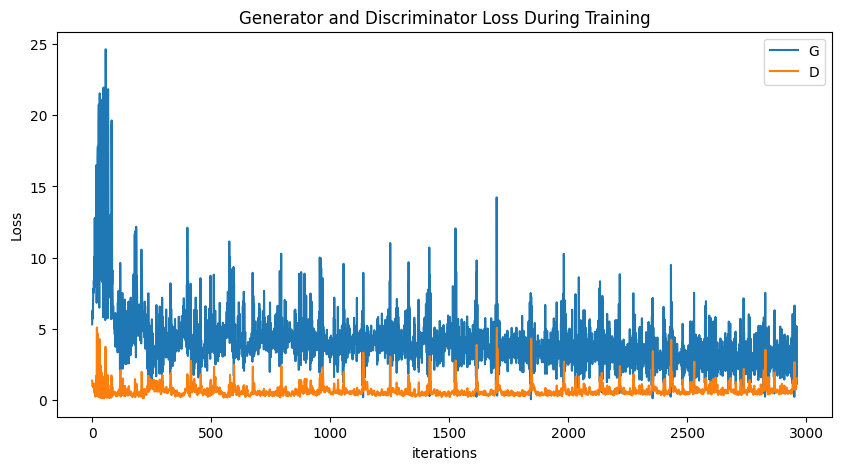

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

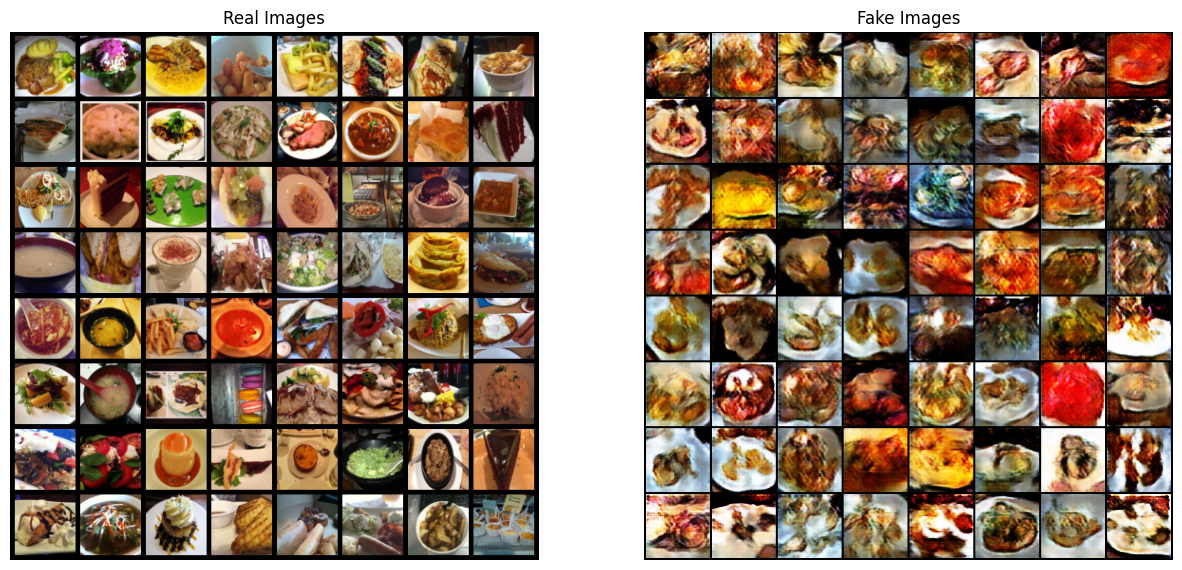

In [22]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()